#### Imports

In [9]:
from __future__ import annotations
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import gym
import numpy as np
import sys
from tqdm import tqdm
import gymnasium as gym
import cv2

#### Create Mountain Car Environment

In [10]:
env = gym.make('MountainCar-v0', render_mode='rgb_array')

#### RL Agent

In [11]:
class MountainCarAgent:
    def __init__(
                    self,
                    learning_rate: float,
                    discount_factor: float,
                    number_of_actions: int,
                    start_epsilon: float,
                    epsilon_decay: float,
                    final_epsilon: float,
                    n: int,
        ):
        """
        Initialize the agent's variables and create Q and e-greedy policy.

        Args:
            learning_rate: The learning rate
            discount_factor: The discount factor for computing the Q-value
            number_of_actions: The number of actions
            start_epsilon: The start value for epsilon,
            epsilon_decay: The amount epsilon decays each episode,
            final_epsilon: The final epsilon value,
            n: The number of steps for n-step expected SARSA
        """
        
        self.learning_rate=learning_rate
        self.discount_factor=discount_factor
        self.number_of_actions=number_of_actions
        self.epsilon=start_epsilon
        self.epsilon_decay=epsilon_decay
        self.final_epsilon=final_epsilon
        self.n=n
        self.training_error = []

        self.position_space  = np.linspace(-1.2, 0.6, 25)
        self.velocity_space = np.linspace(-0.07, 0.07, 25)

        self.stored_rewards = {}
        self.stored_states = {}
        self.stored_actions = {}
        
        # initialize Q
        states = []
        for position in range(len(self.position_space) + 1):
            for velocity in range(len(self.velocity_space) + 1):
                states.append((position, velocity))

        Q = {}
        for state in states:
            for action in range(3):
                Q[(state, action)] = 0.0
        
        self.Q = Q
        self.policy = self.create_epsilon_greedy_policy()

    def get_state(self, state):
        """
        State Aggregation.

        Returns:
            A tuple containing the aggregated position and a velocity values.
        """
        
        position, velocity = state
        position = np.digitize(position, self.position_space)
        velocity = np.digitize(velocity, self.velocity_space)

        return (position, velocity)
    
    def create_epsilon_greedy_policy(self):
        """
        Creates an epsilon greed policy based on the Q values.
            
        Returns:
            A numpy array of length number_of_actions specifying the probability of selecting each 
            action given the observations.
        """

        def policy_fn(state):
            # initialize action values
            A = np.ones(self.number_of_actions, dtype=float) * (self.epsilon/self.number_of_actions)
            
            # get the best action for current state
            best_action = 2
            highest_reward = sys.maxsize * -1
            for a in range(3):
                if self.Q[ (state, a) ] > highest_reward:
                    highest_reward = self.Q[ (state, a) ]
                    best_action = a
            # update probability of current action
            A[best_action] += 1.0 - self.epsilon
            return A
        
        return policy_fn
    
    def decay_epsilon(self):
        """
        Decay epsilon based on decay value. 
        """

        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

    def update(self, tau, n, T):  
        """
        Update Q using n-step Expected SARSA algorithm and aggregated states. 
        """     

        # caluclate return
        G = np.sum([(self.discount_factor**(i-tau-1)) * self.stored_rewards[i % (n+1)] for i  in range(tau+1, min(tau+n, T)+1)])
        
        # calculate value of all actions weighted by their probabilities under pi.
        if tau + n < T:
            exp_sarsa_update = []
            state = self.get_state( self.stored_states[(tau+n) % (n+1)] )
            for a in range( self.number_of_actions ):
                probability_of_a = self.policy( state )[a] 
                value_of_a = self.Q[ (state, a) ] 
                exp_sarsa_update.append( (probability_of_a * value_of_a) )
            exp_sarsa_update = sum( exp_sarsa_update )

            G += (self.discount_factor ** n) * exp_sarsa_update
        
        # update Q value
        s_tau = self.get_state( self.stored_states[tau % (n+1)] ) 
        a_tau = self.stored_actions[tau % (n+1)]
        temporal_difference = G - self.Q[ (s_tau, a_tau) ]
        self.Q[ (s_tau, a_tau) ] += self.learning_rate * temporal_difference
        self.training_error.append(temporal_difference)

#### Instantiate MountainCarAgent

In [12]:
# hyperparameters
number_of_actions = env.action_space.n
n = 10
n_episodes = 30000
discount_factor = 0.95
learning_rate = 0.05
start_epsilon = 1
epsilon_decay = start_epsilon / (n_episodes/2) 
final_epsilon = 0

agent = MountainCarAgent(
    learning_rate=learning_rate,
    discount_factor=discount_factor,
    number_of_actions=number_of_actions,
    start_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    n=n
)

#### Training

In [13]:
# used to create plot of successful episodes
made_it_ratio_list = []
made_it_to_top_per_hundred = 0
made_it_to_top_per_thousand = 0

for i_episode in tqdm(range(n_episodes)):
    # initializations
    agent.stored_rewards = {}
    agent.stored_states = {}
    agent.stored_actions = {}
    
    T = sys.maxsize
    t = -1
    tau = 0
    
    state, info = env.reset()
    
    # get action probabilities from the policy
    action_probs = agent.policy(agent.get_state(state))

    # get action according to the action probabilities
    action = np.random.choice(np.arange(number_of_actions), p=action_probs)
    
    # store current action and state
    agent.stored_actions[0] = action
    agent.stored_states[0] = state
    
    furthest_X = 0
    
    while tau < (T - 1):
        t += 1
        if t < T:
            # observe environments effects after taking sampled action
            next_state, reward, terminated, truncated, info = env.step(action)

            if next_state[0] >= 0.5:
                made_it_to_top_per_hundred += 1
                made_it_to_top_per_thousand += 1
            
            # assign next_state to current state
            state = next_state
            agent.stored_states[(t+1) % (n+1)] = state 
            agent.stored_rewards[(t+1) % (n+1)] = reward
        
            if terminated or truncated:
                T = t + 1
            else:
                # select and store action 
                action_probs = agent.policy(agent.get_state(state))
                action = np.random.choice(np.arange(number_of_actions), p=action_probs)
                agent.stored_actions[(t+1) % (n+1)] = action
        
        tau = t - n + 1
        if tau >= 0:
            agent.update(tau, n, T)

        # watch every 5000th episode after the agent has trained for 10000 episodes
        if i_episode > 9999:
            if i_episode % 5000 == 0:
                img = cv2.cvtColor(env.render(), cv2.COLOR_RGB2BGR)
                cv2.imshow("test", img)
                cv2.waitKey(50)    

    agent.decay_epsilon()

    if i_episode % 100 == 0:
        made_it_ratio = round((made_it_to_top_per_hundred/100)*100,2)
        made_it_ratio_list.append(made_it_ratio)
        made_it_to_top_per_hundred = 0
        if i_episode % 1000 == 0 and i_episode != 0:
            made_it_ratio = round((made_it_to_top_per_thousand/1000)*100,2)
            print(f"\n\tMade it to the top {made_it_to_top_per_thousand} times out of 1000, {made_it_ratio}% of the episodes\n")
            made_it_to_top_per_thousand = 0


  3%|▎         | 1014/30000 [00:14<06:53, 70.18it/s]


	Made it to the top 0 times out of 1000, 0.0% of the episodes



  7%|▋         | 2009/30000 [00:28<06:38, 70.17it/s]


	Made it to the top 0 times out of 1000, 0.0% of the episodes



 10%|█         | 3009/30000 [00:42<06:57, 64.64it/s]


	Made it to the top 0 times out of 1000, 0.0% of the episodes



 13%|█▎        | 4010/30000 [00:57<06:26, 67.18it/s]


	Made it to the top 0 times out of 1000, 0.0% of the episodes



 17%|█▋        | 5010/30000 [01:13<06:26, 64.63it/s]


	Made it to the top 0 times out of 1000, 0.0% of the episodes



 20%|██        | 6012/30000 [01:28<05:59, 66.70it/s]


	Made it to the top 0 times out of 1000, 0.0% of the episodes



 23%|██▎       | 7008/30000 [01:43<05:46, 66.34it/s]


	Made it to the top 0 times out of 1000, 0.0% of the episodes



 27%|██▋       | 8008/30000 [01:58<06:04, 60.38it/s]


	Made it to the top 0 times out of 1000, 0.0% of the episodes



 30%|███       | 9008/30000 [02:14<05:14, 66.83it/s]


	Made it to the top 3 times out of 1000, 0.3% of the episodes



 33%|███▎      | 10008/30000 [02:41<2:43:53,  2.03it/s]


	Made it to the top 19 times out of 1000, 1.9% of the episodes



 37%|███▋      | 11012/30000 [02:56<04:15, 74.33it/s]  


	Made it to the top 344 times out of 1000, 34.4% of the episodes



 40%|████      | 12016/30000 [03:10<04:11, 71.57it/s]


	Made it to the top 650 times out of 1000, 65.0% of the episodes



 43%|████▎     | 13018/30000 [03:22<03:10, 89.24it/s]


	Made it to the top 884 times out of 1000, 88.4% of the episodes



 47%|████▋     | 14018/30000 [03:33<02:58, 89.60it/s] 


	Made it to the top 998 times out of 1000, 99.8% of the episodes



 50%|█████     | 15022/30000 [03:51<36:39,  6.81it/s] 


	Made it to the top 1000 times out of 1000, 100.0% of the episodes



 53%|█████▎    | 16021/30000 [03:59<02:09, 107.68it/s]


	Made it to the top 1000 times out of 1000, 100.0% of the episodes



 57%|█████▋    | 17012/30000 [04:09<02:05, 103.74it/s]


	Made it to the top 1000 times out of 1000, 100.0% of the episodes



 60%|██████    | 18025/30000 [04:18<01:39, 120.11it/s]


	Made it to the top 1000 times out of 1000, 100.0% of the episodes



 63%|██████▎   | 19022/30000 [04:26<01:26, 126.62it/s]


	Made it to the top 1000 times out of 1000, 100.0% of the episodes



 67%|██████▋   | 20025/30000 [04:47<32:01,  5.19it/s] 


	Made it to the top 1000 times out of 1000, 100.0% of the episodes



 70%|███████   | 21014/30000 [04:55<01:21, 110.30it/s]


	Made it to the top 1000 times out of 1000, 100.0% of the episodes



 73%|███████▎  | 22017/30000 [05:05<01:11, 110.93it/s]


	Made it to the top 1000 times out of 1000, 100.0% of the episodes



 77%|███████▋  | 23020/30000 [05:14<01:00, 115.32it/s]


	Made it to the top 1000 times out of 1000, 100.0% of the episodes



 80%|████████  | 24012/30000 [05:23<00:57, 103.50it/s]


	Made it to the top 1000 times out of 1000, 100.0% of the episodes



 83%|████████▎ | 25019/30000 [05:40<11:42,  7.09it/s] 


	Made it to the top 1000 times out of 1000, 100.0% of the episodes



 87%|████████▋ | 26026/30000 [05:49<00:33, 118.53it/s]


	Made it to the top 1000 times out of 1000, 100.0% of the episodes



 90%|█████████ | 27018/30000 [05:58<00:29, 101.93it/s]


	Made it to the top 1000 times out of 1000, 100.0% of the episodes



 93%|█████████▎| 28020/30000 [06:08<00:21, 92.44it/s] 


	Made it to the top 1000 times out of 1000, 100.0% of the episodes



 97%|█████████▋| 29026/30000 [06:19<00:10, 90.34it/s]


	Made it to the top 1000 times out of 1000, 100.0% of the episodes



100%|██████████| 30000/30000 [06:30<00:00, 76.85it/s]


#### Plot results

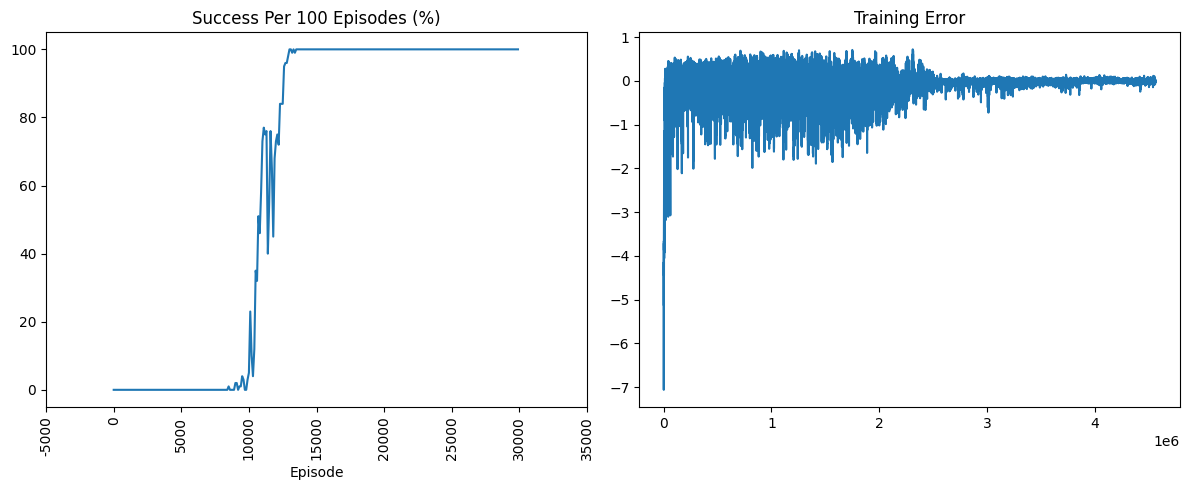

In [14]:
rolling_length = 500
x = range(0, 300)
fig, ax = plt.subplots(ncols=2, figsize=(12,5))

ax[0].set_title("Success Per 100 Episodes (%)")
ax[0].plot(x, made_it_ratio_list)
ax[0].set_xlabel("Episode")
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(50))
ax[0].set_xticks([tick for tick in ax[0].get_xticks()])
ax[0].set_xticklabels([int(val * 100) for val in ax[0].get_xticks()], rotation="vertical")

ax[1].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
ax[1].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()